# Test Predictor

In [46]:
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import kalman_predict
from Prediction import LSTM_predict
import imp
import matplotlib.pyplot as plt

In [2]:
det = detector.Detector_v4()

Detector initiated successfully


## Kalman Predictor

In [23]:
traj_predictor = kalman_predict.ConstantVelocityKalmanPredictor(forecast_horizon=60)
p = predictor.HitPredictor(traj_predictor, det, history_size=5288)

In [24]:
imp.reload(visualize)

vid_path = "../Pogona_Pursuit/Arena/experiments/fast_cockroach_line_20200730T131606/trial1/videos/20200730-131607/19506468.avi"
out_path = "labelled/test_kalman_predictor.mp4"

p.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.predictor_visualizer(p)])

100%|██████████| 5080/5080 [02:24<00:00, 35.25it/s]


## Test RED (lstm+dense) Predictor

In [244]:
imp.reload(LSTM_predict)
imp.reload(predictor)
imp.reload(visualize)

<module 'Prediction.visualize' from '/app/Pogona_realtime/Prediction/visualize.py'>

In [250]:
model_path = 'Prediction/traj_models/RED/model_16_24_h32_best.pth'
red_predictor = LSTM_predict.REDPredictor(model_path, 16, 24, hidden_size=32)
red_hitp = predictor.HitPredictor(red_predictor, det, history_size=5288, prediction_y_threshold=900)

In [ ]:
vid_path = "../Pogona_Pursuit/Arena/experiments/fast_cockroach_line_20200730T131606/trial1/videos/20200730-131607/19506468.avi"
out_path = "labelled/test_red1624_265e_h32_predictor.mp4"

red_hitp.reset(history_size=5288)
visualize.process_video(vid_path, out_path, [visualize.predictor_visualizer(red_hitp)])

 91%|█████████▏| 4645/5080 [02:13<00:12, 34.92it/s]

In [247]:
red_hitp.forecasts[60]

array([[861.61036691, 804.79697061],
       [861.76925268, 804.72620213],
       [862.02007188, 804.675472  ],
       [862.36913661, 804.67548648],
       [862.73166099, 804.67376638],
       [863.18446268, 804.68322696],
       [863.58856924, 804.66262528],
       [864.00353477, 804.69567456],
       [864.47081025, 804.73510178],
       [864.92157336, 804.7507731 ],
       [865.35339297, 804.80218187],
       [865.83946969, 804.82385796],
       [866.30263467, 804.83434297],
       [866.69464557, 804.84661949],
       [867.06874341, 804.87738   ],
       [867.40941592, 804.91605266],
       [867.74185781, 804.98194481],
       [868.0523302 , 805.05609493],
       [868.28882477, 805.15725798],
       [868.50150843, 805.21606584],
       [868.6737972 , 805.263766  ],
       [868.84576888, 805.26452107],
       [868.96103797, 805.21953151],
       [869.12961698, 805.22035179]])

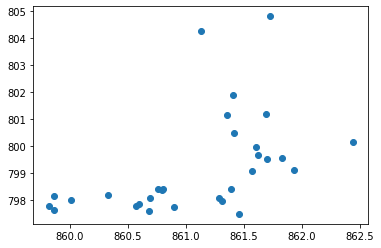

In [49]:
cents = detector.xywh_to_centroid(red_hitp.history[60:90])
plt.scatter(cents[:, 0], cents[:, 1])

# Resize speeds

In [ ]:
import cv2 as cv

In [19]:
im = cv.imread('./Calib_frames/blk_sqr.jpg',)
im = cv.cvtColor(im,cv.COLOR_BGR2GRAY)

In [24]:
im416 = cv.resize(im,(416,416))
im800_600 = cv.resize(im,(800,600))

In [25]:
im.shape

(1080, 1440)

In [43]:
r = np.random.rand(1440,1080)

In [44]:
%timeit cv.resize(r,(416,416))

214 µs ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
%timeit p.handle_frame(im416)

11.6 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit p.handle_frame(im800_600)

11.9 ms ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
%timeit p.handle_frame(im)

12.6 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Check net object

In [5]:
import inspect
from Prediction.detector import Detector_v4
from pprint import pprint
from ctypes import CDLL, RTLD_GLOBAL, c_void_p, c_int
import ctypes
from Prediction.Yolo4.darknet import IMAGE

In [3]:
lib = CDLL("./Prediction/Yolo4/libdarknet.so", RTLD_GLOBAL)
det = Detector_v4()

Detector initiated successfully


In [9]:
net_p = ctypes.cast(det.net, ctypes.c_void_p)
inspect.getmembers(net_p)
type(net_p)

ctypes.c_void_p

In [10]:
get_network_layer = lib.get_network_layer
get_network_layer.argtypes = [c_void_p, c_int]
get_network_layer.restype = c_void_p

In [12]:
layer = get_network_layer(det.net, 0)

"""
struct layer {
    LAYER_TYPE type;
    ACTIVATION activation;
    ACTIVATION lstm_activation;
    COST_TYPE cost_type;
    void(*forward)   (struct layer, struct network_state);
    void(*backward)  (struct layer, struct network_state);
    void(*update)    (struct layer, int, float, float, float);
    void(*forward_gpu)   (struct layer, struct network_state);
    void(*backward_gpu)  (struct layer, struct network_state);
    void(*update_gpu)    (struct layer, int, float, float, float, float);
    layer *share_layer;
    int train;
    int avgpool;
    int batch_normalize;
    int shortcut;
    int batch;
    int dynamic_minibatch;
    int forced;
    int flipped;
    int inputs;
    int outputs;
    float mean_alpha;
    int nweights;
    int nbiases;
    int extra;
    int truths;
    int h, w, c;
    int out_h, out_w, out_c;
    int n;
    int max_boxes;
    int truth_size;
    int groups;
    int group_id;
    int size;
    int side;
    int stride;
    int stride_x;
    int stride_y;
    int dilation;
    int antialiasing;
    int maxpool_depth;
    int maxpool_zero_nonmax;
    int out_channels;
    float reverse;
    int coordconv;
    int flatten;
    int spatial;
    int pad;
    int sqrt;
    int flip;
    int index;
    int scale_wh;
    int binary;
    int xnor;
    int peephole;
    int use_bin_output;
    int keep_delta_gpu;
    int optimized_memory;
    int steps;
    int history_size;
    int bottleneck;
    float time_normalizer;
    int state_constrain;
    int hidden;
    int truth;
    float smooth;
    float dot;
    int deform;
    int grad_centr;
    int sway;
    int rotate;
    int stretch;
    int stretch_sway;
    float angle;
    float jitter;
    float resize;
    float saturation;
    float exposure;
    float shift;
    float ratio;
    float learning_rate_scale;
    float clip;
    int focal_loss;
    float *classes_multipliers;
    float label_smooth_eps;
    int noloss;
    int softmax;
    int classes;
    int detection;
    int embedding_layer_id;
    float *embedding_output;
    int embedding_size;
    float sim_thresh;
    int track_history_size;
    int dets_for_track;
    int dets_for_show;
    float track_ciou_norm;
    int coords;
    int background;
    int rescore;
    int objectness;
    int does_cost;
    int joint;
    int noadjust;
    int reorg;
    int log;
    int tanh;
    int *mask;
    int total;
    float bflops;

    int adam;
    float B1;
    float B2;
    float eps;

    int t;

    float alpha;
    float beta;
    float kappa;

    float coord_scale;
    float object_scale;
    float noobject_scale;
    float mask_scale;
    float class_scale;
    int bias_match;
    float random;
    float ignore_thresh;
    float truth_thresh;
    float iou_thresh;
    float thresh;
    float focus;
    int classfix;
    int absolute;
    int assisted_excitation;

    int onlyforward;
    int stopbackward;
    int train_only_bn;
    int dont_update;
    int burnin_update;
    int dontload;
    int dontsave;
    int dontloadscales;
    int numload;

    float temperature;
    float probability;
    float dropblock_size_rel;
    int dropblock_size_abs;
    int dropblock;
    float scale;

    int receptive_w;
    int receptive_h;
    int receptive_w_scale;
    int receptive_h_scale;

    char  * cweights;
    int   * indexes;
    int   * input_layers;
    int   * input_sizes;
    float **layers_output;
    float **layers_delta;
    WEIGHTS_TYPE_T weights_type;
    WEIGHTS_NORMALIZATION_T weights_normalization;
    int   * map;
    int   * counts;
    float ** sums;
    float * rand;
    float * cost;
    int *labels;
    float *cos_sim;
    float *exp_cos_sim;
    float *p_constrastive;
    contrastive_params *contrast_p_gpu;
    float * state;
    float * prev_state;
    float * forgot_state;
    float * forgot_delta;
    float * state_delta;
    float * combine_cpu;
    float * combine_delta_cpu;

    float *concat;
    float *concat_delta;

    float *binary_weights;

    float *biases;
    float *bias_updates;

    float *scales;
    float *scale_updates;

    float *weights;
    float *weight_updates;

    float scale_x_y;
    int objectness_smooth;
    float max_delta;
    float uc_normalizer;
    float iou_normalizer;
    float cls_normalizer;
    IOU_LOSS iou_loss;
    IOU_LOSS iou_thresh_kind;
    NMS_KIND nms_kind;
    float beta_nms;
    YOLO_POINT yolo_point;

    char *align_bit_weights_gpu;
    float *mean_arr_gpu;
    float *align_workspace_gpu;
    float *transposed_align_workspace_gpu;
    int align_workspace_size;

    char *align_bit_weights;
    float *mean_arr;
    int align_bit_weights_size;
    int lda_align;
    int new_lda;
    int bit_align;

    float *col_image;
    float * delta;
    float * output;
    float * activation_input;
    int delta_pinned;
    int output_pinned;
    float * loss;
    float * squared;
    float * norms;

    float * spatial_mean;
    float * mean;
    float * variance;

    float * mean_delta;
    float * variance_delta;

    float * rolling_mean;
    float * rolling_variance;

    float * x;
    float * x_norm;

    float * m;
    float * v;

    float * bias_m;
    float * bias_v;
    float * scale_m;
    float * scale_v;


    float *z_cpu;
    float *r_cpu;
    float *h_cpu;
    float *stored_h_cpu;
    float * prev_state_cpu;

    float *temp_cpu;
    float *temp2_cpu;
    float *temp3_cpu;

    float *dh_cpu;
    float *hh_cpu;
    float *prev_cell_cpu;
    float *cell_cpu;
    float *f_cpu;
    float *i_cpu;
    float *g_cpu;
    float *o_cpu;
    float *c_cpu;
    float *stored_c_cpu;
    float *dc_cpu;

    float *binary_input;
    uint32_t *bin_re_packed_input;
    char *t_bit_input;

    struct layer *input_layer;
    struct layer *self_layer;
    struct layer *output_layer;

    struct layer *reset_layer;
    struct layer *update_layer;
    struct layer *state_layer;

    struct layer *input_gate_layer;
    struct layer *state_gate_layer;
    struct layer *input_save_layer;
    struct layer *state_save_layer;
    struct layer *input_state_layer;
    struct layer *state_state_layer;

    struct layer *input_z_layer;
    struct layer *state_z_layer;

    struct layer *input_r_layer;
    struct layer *state_r_layer;

    struct layer *input_h_layer;
    struct layer *state_h_layer;

    struct layer *wz;
    struct layer *uz;
    struct layer *wr;
    struct layer *ur;
    struct layer *wh;
    struct layer *uh;
    struct layer *uo;
    struct layer *wo;
    struct layer *vo;
    struct layer *uf;
    struct layer *wf;
    struct layer *vf;
    struct layer *ui;
    struct layer *wi;
    struct layer *vi;
    struct layer *ug;
    struct layer *wg;

    tree *softmax_tree;

    size_t workspace_size;

//#ifdef GPU
    int *indexes_gpu;

    float *z_gpu;
    float *r_gpu;
    float *h_gpu;
    float *stored_h_gpu;
    float *bottelneck_hi_gpu;
    float *bottelneck_delta_gpu;

    float *temp_gpu;
    float *temp2_gpu;
    float *temp3_gpu;

    float *dh_gpu;
    float *hh_gpu;
    float *prev_cell_gpu;
    float *prev_state_gpu;
    float *last_prev_state_gpu;
    float *last_prev_cell_gpu;
    float *cell_gpu;
    float *f_gpu;
    float *i_gpu;
    float *g_gpu;
    float *o_gpu;
    float *c_gpu;
    float *stored_c_gpu;
    float *dc_gpu;

    // adam
    float *m_gpu;
    float *v_gpu;
    float *bias_m_gpu;
    float *scale_m_gpu;
    float *bias_v_gpu;
    float *scale_v_gpu;

    float * combine_gpu;
    float * combine_delta_gpu;

    float * forgot_state_gpu;
    float * forgot_delta_gpu;
    float * state_gpu;
    float * state_delta_gpu;
    float * gate_gpu;
    float * gate_delta_gpu;
    float * save_gpu;
    float * save_delta_gpu;
    float * concat_gpu;
    float * concat_delta_gpu;

    float *binary_input_gpu;
    float *binary_weights_gpu;
    float *bin_conv_shortcut_in_gpu;
    float *bin_conv_shortcut_out_gpu;

    float * mean_gpu;
    float * variance_gpu;
    float * m_cbn_avg_gpu;
    float * v_cbn_avg_gpu;

    float * rolling_mean_gpu;
    float * rolling_variance_gpu;

    float * variance_delta_gpu;
    float * mean_delta_gpu;

    float * col_image_gpu;

    float * x_gpu;
    float * x_norm_gpu;
    float * weights_gpu;
    float * weight_updates_gpu;
    float * weight_deform_gpu;
    float * weight_change_gpu;

    float * weights_gpu16;
    float * weight_updates_gpu16;

    float * biases_gpu;
    float * bias_updates_gpu;
    float * bias_change_gpu;

    float * scales_gpu;
    float * scale_updates_gpu;
    float * scale_change_gpu;

    float * input_antialiasing_gpu;
    float * output_gpu;
    float * output_avg_gpu;
    float * activation_input_gpu;
    float * loss_gpu;
    float * delta_gpu;
    float * cos_sim_gpu;
    float * rand_gpu;
    float * drop_blocks_scale;
    float * drop_blocks_scale_gpu;
    float * squared_gpu;
    float * norms_gpu;

    float *gt_gpu;
    float *a_avg_gpu;

    int *input_sizes_gpu;
    float **layers_output_gpu;
    float **layers_delta_gpu;
#ifdef CUDNN
    cudnnTensorDescriptor_t srcTensorDesc, dstTensorDesc;
    cudnnTensorDescriptor_t srcTensorDesc16, dstTensorDesc16;
    cudnnTensorDescriptor_t dsrcTensorDesc, ddstTensorDesc;
    cudnnTensorDescriptor_t dsrcTensorDesc16, ddstTensorDesc16;
    cudnnTensorDescriptor_t normTensorDesc, normDstTensorDesc, normDstTensorDescF16;
    cudnnFilterDescriptor_t weightDesc, weightDesc16;
    cudnnFilterDescriptor_t dweightDesc, dweightDesc16;
    cudnnConvolutionDescriptor_t convDesc;
    cudnnConvolutionFwdAlgo_t fw_algo, fw_algo16;
    cudnnConvolutionBwdDataAlgo_t bd_algo, bd_algo16;
    cudnnConvolutionBwdFilterAlgo_t bf_algo, bf_algo16;
    cudnnPoolingDescriptor_t poolingDesc;
#else   // CUDNN
    void* srcTensorDesc, *dstTensorDesc;
    void* srcTensorDesc16, *dstTensorDesc16;
    void* dsrcTensorDesc, *ddstTensorDesc;
    void* dsrcTensorDesc16, *ddstTensorDesc16;
    void* normTensorDesc, *normDstTensorDesc, *normDstTensorDescF16;
    void* weightDesc, *weightDesc16;
    void* dweightDesc, *dweightDesc16;
    void* convDesc;
    UNUSED_ENUM_TYPE fw_algo, fw_algo16;
    UNUSED_ENUM_TYPE bd_algo, bd_algo16;
    UNUSED_ENUM_TYPE bf_algo, bf_algo16;
    void* poolingDesc;
#endif  // CUDNN
//#endif  // GPU
};
"""

94731766474080

In [ ]:
class DarknetLayer(ctypes.Structure):
    _fields_ = []

# Data for Pytorch

In [53]:
import torch
from Prediction import dataset
from Prediction import LSTM_predict as lstm
from Prediction import train_eval
import numpy as np
import pandas as pd
import pickle
import imp

In [207]:
imp.reload(dataset)
imp.reload(train_eval)

<module 'Prediction.train_eval' from '/app/Pogona_realtime/Prediction/train_eval.py'>

In [197]:
imp.reload(lstm)

<module 'Prediction.LSTM_predict' from '/app/Pogona_realtime/Prediction/LSTM_predict.py'>

In [163]:
with open('Data/all_exper.p','rb') as f:
    d = pickle.load(f)

In [164]:
all_df = dataset.get_unified_df(d,mult=True)

In [ ]:
all

In [136]:
test = all_df.head()

In [141]:
test = test.assign(vx=test['centroid_x'].diff().values)

In [142]:
test

centroid_x  centroid_y      left_x       top_y  \
line_20200803T081429 1  1001.973328  744.859730  951.973328  704.859730   
                     1  1001.659409  743.726990  951.659409  703.726990   
                     1  1001.980980  744.570805  951.980980  704.570805   
                     1  1001.342079  743.889633  951.342079  703.889633   
                     1  1001.882412  744.529049  951.882412  704.529049   

                            right_x    bottom_y      conf  num_bbox  \
line_20200803T081429 1  1053.493713  785.472546  0.988369       1.0   
                     1  1052.953751  785.046570  0.993245       1.0   
                     1  1052.929787  785.393673  0.992465       1.0   
                     1  1052.917442  785.432266  0.992419       1.0   
                     1  1053.409702  785.115849  0.993147       1.0   

                                           timestamp  hit_x  hit_y  bug_x  \
line_20200803T081429 1 2020-08-03 08:14:29.869937658    NaN    NaN    NaN   
                     1 2020-08-03 08:14:29.918991566    NaN    NaN    NaN   
                     1 2020-08-03 08:14:29.934581041    NaN    NaN    NaN   
                     1 2020-08-03 08:14:29.947722673    NaN    NaN    NaN   
                     1 2020-08-03 08:14:29.959564209    NaN    NaN    NaN   

                        bug_y touch_ts    hit  frame_ind        vx  
line_20200803T081429 1    NaN      NaT  False          0       NaN  
                     1    NaN      NaT  False          1 -0.313919  
                     1    NaN      NaT  False          2  0.321571  
                     1    NaN      NaT  False          3 -0.638901  
                     1    NaN      NaT  False          4  0.540333

In [137]:
test['vx'] = pd.Series(test['centroid_x'].diff().values)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [165]:
inp_labels = ['centroid_x', 'centroid_y']
out_labels = ['centroid_x', 'centroid_y']
inp_seq = 16
out_seq = 24

In [166]:
tensor_list_X, tensor_list_Y = [], []

In [167]:
for trial in all_df.index.unique():
    trial_df = all_df.loc[trial]
    trial_df = trial_df.assign(vx=trial_df['centroid_x'].diff().values,
                              vy=trial_df['centroid_y'].diff().values)
    X, Y = dataset.trial_to_samples(trial_df, input_labels = inp_labels,
                                   output_labels=out_labels, input_seq_size=inp_seq,
                                   output_seq_size=out_seq)
    tensor_list_X.append(X)
    tensor_list_Y.append(Y)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


In [168]:
all_X = torch.cat(tensor_list_X)
all_Y = torch.cat(tensor_list_Y)

In [169]:
train_dataloader, test_dataloader = train_eval.create_dataloader(all_X, all_Y)

In [248]:
net = lstm.LSTMdense(2,2,out_seq, hidden_size=32)

In [249]:
best_epoch, best_ADE = train_eval.train_trajectory_model(net, train_dataloader, test_dataloader, 300, 
              'Prediction/traj_models/RED/', eval_freq=5, epoch_print_freq=5, model_name="model_16_24_h32")

epoch: 0, loss: 1281.671, epoch time: 1.437
++++++++++++++++
Eval epoch: 0, Test set mean ADE 3.282
epoch: 5, loss: 1163.191, epoch time: 1.592
++++++++++++++++
Eval epoch: 5, Test set mean ADE 3.070
epoch: 10, loss: 1134.329, epoch time: 1.497
++++++++++++++++
Eval epoch: 10, Test set mean ADE 3.004
epoch: 15, loss: 1110.864, epoch time: 1.459
++++++++++++++++
Eval epoch: 15, Test set mean ADE 2.952
epoch: 20, loss: 1090.268, epoch time: 1.553
++++++++++++++++
Eval epoch: 20, Test set mean ADE 2.922
epoch: 25, loss: 1072.478, epoch time: 1.481
++++++++++++++++
Eval epoch: 25, Test set mean ADE 2.887
epoch: 30, loss: 1055.722, epoch time: 1.511
++++++++++++++++
Eval epoch: 30, Test set mean ADE 2.857
epoch: 35, loss: 1040.087, epoch time: 1.455
++++++++++++++++
Eval epoch: 35, Test set mean ADE 2.831
epoch: 40, loss: 1026.736, epoch time: 1.454
++++++++++++++++
Eval epoch: 40, Test set mean ADE 2.803
epoch: 45, loss: 1012.521, epoch time: 1.597
++++++++++++++++
Eval epoch: 45, Test set

In [86]:
best_epoch, best_ADE

(2, 27661.298828125)

In [219]:
imp.reload(train_eval)

<module 'Prediction.train_eval' from '/app/Pogona_realtime/Prediction/train_eval.py'>

In [222]:
inp_lens = range(12, 49, 8)
out_lens = inp_lens

ADEs = train_eval.grid_input_output(lstm.LSTMdense, all_df, inp_lens, out_lens, inp_labels, out_labels, 'Prediction/traj_models/RED/', 401)

Training with input_seq_len=12, output_seq_len=12
epoch: 0, loss: 777.553, epoch time: 1.367
++++++++++++++++
Eval epoch: 0, Test set mean ADE 2.219
epoch: 50, loss: 337.948, epoch time: 1.450
epoch: 100, loss: 268.827, epoch time: 1.472
++++++++++++++++
Eval epoch: 100, Test set mean ADE 2.496
epoch: 150, loss: 241.172, epoch time: 1.438
epoch: 200, loss: 227.790, epoch time: 1.429
++++++++++++++++
Eval epoch: 200, Test set mean ADE 2.527
epoch: 250, loss: 219.896, epoch time: 1.480
epoch: 300, loss: 214.207, epoch time: 1.455
++++++++++++++++
Eval epoch: 300, Test set mean ADE 2.549
epoch: 350, loss: 210.148, epoch time: 1.434
epoch: 400, loss: 206.672, epoch time: 1.524
++++++++++++++++
Eval epoch: 400, Test set mean ADE 2.563
Finished training
Training with input_seq_len=12, output_seq_len=20
epoch: 0, loss: 1068.994, epoch time: 1.496
++++++++++++++++
Eval epoch: 0, Test set mean ADE 2.946
epoch: 50, loss: 444.467, epoch time: 1.441
epoch: 100, loss: 335.257, epoch time: 1.513
+++

In [256]:
ADEs = ADEs.astype('float64')

In [257]:
ADEs.values

array([[2.2193172 , 2.94573975, 3.66684103, 4.36968851, 4.93245792],
       [2.193115  , 2.93659759, 3.61216402, 4.30841875, 4.86428928],
       [2.17989755, 2.90543628, 3.60302877, 4.27222824, 4.90603304],
       [2.18515611, 2.88209367, 3.57404041, 4.25071716, 4.84111214],
       [2.16800404, 2.9057312 , 3.58273959, 4.23318243, 4.79080868]])

In [261]:
ADEs

,12,20,28,36,44
12,2.219317,2.945740,3.666841,4.369689,4.932458
20,2.193115,2.936598,3.612164,4.308419,4.864289
28,2.179898,2.905436,3.603029,4.272228,4.906033
36,2.185156,2.882094,3.574040,4.250717,4.841112
44,2.168004,2.905731,3.582740,4.233182,4.790809


Text(0, 0.5, 'input length')

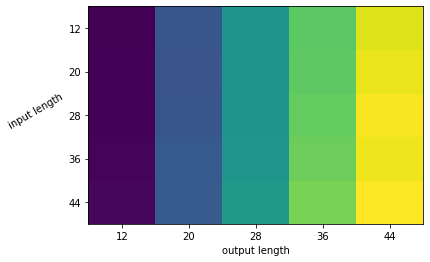

In [278]:
plt.pcolor(ADEs)
plt.yticks(np.arange(0.5, len(ADEs.index), 1)[::-1], ADEs.columns)
plt.xticks(np.arange(0.5, len(ADEs.columns), 1), ADEs.index)
plt.xlabel('output length')
plt.ylabel('input length',rotation=30,labelpad=30)

In [275]:
ADEs

,12,20,28,36,44
12,2.219317,2.945740,3.666841,4.369689,4.932458
20,2.193115,2.936598,3.612164,4.308419,4.864289
28,2.179898,2.905436,3.603029,4.272228,4.906033
36,2.185156,2.882094,3.574040,4.250717,4.841112
44,2.168004,2.905731,3.582740,4.233182,4.790809


In [16]:
import Prediction.LSTM_predict as lstm

In [18]:
net.eval()

LSTMdense(
  (LSTM): LSTM(2, 256, num_layers=2)
  (dense): Linear(in_features=256, out_features=48, bias=True)
)

In [26]:
total_ADE = 0
count = 0
device = torch.device('cuda')
for (x, y) in train_dataloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = net(x)

    total_ADE += lstm.calc_ADE(pred, y)
    count += 1

print("++++++++++++++++")
print(f"Test set mean ADE {total_ADE/count:.3f}")


++++++++++++++++
Test set mean ADE 3.694


In [49]:
net.output_seq_size

30

In [96]:
x,y = iter(train_dataloader).next()

In [279]:
import glob

In [281]:
glob.glob('../Pogona_Pursuit/Arena/experiments/*')

['../Pogona_Pursuit/Arena/experiments/initial_20200727T071226',
 '../Pogona_Pursuit/Arena/experiments/initial_20200727T073708',
 '../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358',
 '../Pogona_Pursuit/Arena/experiments/fps_check_20200727T083454',
 '../Pogona_Pursuit/Arena/experiments/test_20200727T100404',
 '../Pogona_Pursuit/Arena/experiments/test_fps_20200727T102701',
 '../Pogona_Pursuit/Arena/experiments/fps_check_20200727T105124',
 '../Pogona_Pursuit/Arena/experiments/fps_check_20200727T110833',
 '../Pogona_Pursuit/Arena/experiments/delete_20200727T161744',
 '../Pogona_Pursuit/Arena/experiments/initial_20200729T071920',
 '../Pogona_Pursuit/Arena/experiments/worm_20200729T074653',
 '../Pogona_Pursuit/Arena/experiments/worm_20200729T075548',
 '../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031',
 '../Pogona_Pursuit/Arena/experiments/vegetables_20200729T084925',
 '../Pogona_Pursuit/Arena/experiments/worm_20200729T090421',
 '../Pogona_Pursuit/Arena/experiments/ve